In [1]:
import glob
import logging
import os
import random
import json

import numpy as np
import torch
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler,
                              TensorDataset)
import random
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data.distributed import DistributedSampler
from tqdm import tqdm_notebook, trange

from transformers import (WEIGHTS_NAME, BertConfig, BertForSequenceClassification, BertTokenizer,
                                  XLMConfig, XLMForSequenceClassification, XLMTokenizer, 
                                  XLNetConfig, XLNetForSequenceClassification, XLNetTokenizer,
                                  RobertaConfig, RobertaForSequenceClassification, RobertaTokenizer)
from transformers import GPT2DoubleHeadsModel, GPT2Tokenizer, GPT2Config
from transformers import AdamW, WarmupLinearSchedule

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

To use data.metrics please install scikit-learn. See https://scikit-learn.org/stable/index.html


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'GeForce GTX 1080 Ti'

## Load the dataset

Please find the required code to generate the dataset in dataset generation. Dataset generation can be a little bit time consuming, if you want to get the datasets, please send us an email [ANONYMIZED]

Once you have the dataset you should change the path to the actual directory.

In [5]:
import pandas as pd

directory = "../data/bot_detection/"
train = pd.read_csv(directory + "train.csv", header=None)
test = pd.read_csv(directory + "test.csv", header=None)

train = pd.DataFrame({
    'id':range(len(train)),
    'label':train[0],
    'mark':['a']*train.shape[0],
    'text': train[1].replace(r'\n', ' ', regex=True)
})


test = pd.DataFrame({
    'id':range(len(test)),
    'label':test[0],
    'mark':['a']*test.shape[0],
    'text': test[1].replace(r'\n', ' ', regex=True)
})

#train = train[:10000]
#test = test[:1000]

#train.to_csv(directory + 'data/' 'train.tsv', sep='\t', index=False, header=False)
#test.to_csv(directory + 'data/' 'test.tsv', sep='\t', index=False, header=False)

print(np.sum(test["label"]))
print(np.sum(train["label"]))

#directory = "./09_BERT/Large_Dataset/"
#train = pd.read_csv(directory + "train.tsv", header=None, delimiter = '\t')
#test = pd.read_csv(directory + "dev.tsv", header=None, delimiter = '\t')

train.columns = ["index", "label", "mark", "tweet"]
test.columns =  ["index", "label", "mark", "tweet"]

train

44288
220506


,index,label,mark,tweet
0,0,1,a,25 Non-Profit WordPress Themes for Charitable ...
1,1,0,a,Lunch news: Eat's chilli chicken rice pot thin...
2,2,0,a,when you wake up thinking its friday 🙄 https:/...
3,3,0,a,@Krimlin_GG Yeah us too but if you compare us ...
4,4,0,a,@Raghad3 @AmalNadhreen @prkhalid_center Go for...
...,...,...,...,...
499995,499995,0,a,@enemybieber ok ok now we reaching reaching
499996,499996,1,a,Philadelphia NAACP Takes Issue With DA's Rulin...
499997,499997,1,a,Federal Conservative leader Andrew Scheer spea...
499998,499998,0,a,"@nithinrrai Noted, Have informed sector traffi..."


## Preprocessing

In [21]:
model_name = "gpt2"

if model_name == "BERT":
    train_sentences = train.tweet.values
    train_sentences = ["[CLS] " + sentence + " [SEP]" for sentence in train_sentences]
    train_labels = train.label.values

    test_sentences = test.tweet.values
    test_sentences = ["[CLS] " + sentence + " [SEP]" for sentence in test_sentences]
    test_labels = test.label.values

elif model_name == "gpt2":
    train_sentences = train.tweet.values
    train_labels = train.label.values
    test_sentences = test.tweet.values
    test_labels = test.label.values    

In [22]:
max_length = 128
if model_name == "BERT":
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
elif model_name == "gpt2":
    tokenizer = GPT2Tokenizer.from_pretrained('gpt2', do_lower_case=True)

train_tokenized_tweets = [tokenizer.tokenize(sent) for sent in train_sentences]
test_tokenized_tweets = [tokenizer.tokenize(sent) for sent in test_sentences]

print ("Tokenize the first sentence:")
print (train_tokenized_tweets[:3])

INFO:transformers.tokenization_utils:loading file https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-vocab.json from cache at /home/test/.cache/torch/transformers/f2808208f9bec2320371a9f5f891c184ae0b674ef866b79c58177067d15732dd.1512018be4ba4e8726e41b9145129dc30651ea4fec86aa61f4b9f40bf94eac71
INFO:transformers.tokenization_utils:loading file https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-merges.txt from cache at /home/test/.cache/torch/transformers/d629f792e430b3c76a1291bb2766b0a047e36fae0588f9dbc1ae51decdff691b.70bec105b4158ed9a1747fea67a43f5dee97855c64d62b6ec3742f4cfdb5feda


Tokenize the first sentence:
[['25', 'ĠNon', '-', 'Pro', 'fit', 'ĠWordPress', 'ĠThe', 'mes', 'Ġfor', 'ĠChar', 'itable', 'ĠOrganizations', 'Ġhttps', '://', 't', '.', 'co', '/', '4', 'y', 'H', 'gh', 'l', '3', 'll', 'R', 'Ġ#', 'creat', 'ive', 'Ġ#', 'art'], ['L', 'unch', 'Ġnews', ':', 'ĠEat', "'s", 'Ġchill', 'i', 'Ġchicken', 'Ġrice', 'Ġpot', 'Ġthing', 'Ġgets', 'Ġa', 'Ġ14', 'Ġout', 'Ġof', 'Ġ10', 'Ġfrom', 'Ġme', '.'], ['when', 'Ġyou', 'Ġwake', 'Ġup', 'Ġthinking', 'Ġits', 'Ġfr', 'iday', 'ĠðŁ', 'Ļ', 'Ħ', 'Ġhttps', '://', 't', '.', 'co', '/', 'b', 'K', 'Im', 'Y', 'ha', 'D', 'Ar']]


In [23]:
MAX_LEN = 128
train_input_ids = [tokenizer.convert_tokens_to_ids(x) for x in train_tokenized_tweets]
test_input_ids = [tokenizer.convert_tokens_to_ids(x) for x in test_tokenized_tweets]
print(train_input_ids[:3])

[[1495, 8504, 12, 2964, 11147, 22477, 383, 6880, 329, 3178, 4674, 41846, 3740, 1378, 83, 13, 1073, 14, 19, 88, 39, 456, 75, 18, 297, 49, 1303, 20123, 425, 1303, 433], [43, 3316, 1705, 25, 27574, 338, 20493, 72, 9015, 11464, 1787, 1517, 3011, 257, 1478, 503, 286, 838, 422, 502, 13], [12518, 345, 7765, 510, 3612, 663, 1216, 2567, 12520, 247, 226, 3740, 1378, 83, 13, 1073, 14, 65, 42, 3546, 56, 3099, 35, 3163]]


In [24]:
train_input_ids = pad_sequences(train_input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
test_input_ids = pad_sequences(test_input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [25]:
train_attention_masks = []
test_attention_masks = []

for seq in train_input_ids:
    seq_mask = [float(i>0) for i in seq]
    train_attention_masks.append(seq_mask)
    
for seq in test_input_ids:
    seq_mask = [float(i>0) for i in seq]
    test_attention_masks.append(seq_mask)

In [26]:
train_inputs = torch.tensor(train_input_ids)
train_masks = torch.tensor(train_attention_masks)
train_labels = torch.tensor(train_labels)

test_inputs = torch.tensor(test_input_ids)
test_masks = torch.tensor(test_attention_masks)
test_labels = torch.tensor(test_labels)

#### Create the generators

In [27]:
batch_size = 8
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

#### Model and parameters

In [28]:
if model_name == "BERT":
    model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
elif model_name == "gpt2":
    model = GPT2DoubleHeadsModel.from_pretrained("gpt2", num_labels = 2)
model.cuda()

INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-config.json from cache at /home/test/.cache/torch/transformers/4be02c5697d91738003fb1685c9872f284166aa32e061576bbe6aaeb95649fcf.db13c9bc9c7bdd738ec89e069621d88e05dc670366092d809a9cbcac6798e24e
INFO:transformers.configuration_utils:Model config {
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "finetuning_task": null,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_layer": 12,
  "n_positions": 1024,
  "num_labels": 2,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pruned_heads": {},
  "resid_pdrop": 0.1,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summar

GPT2DoubleHeadsModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2):

In [29]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters,
                     lr=2e-5,)

## Fine-Tuning

The fine tuning of a model with the 500000 examples in the training set takes around 5 hours for 2 epochs.

In [30]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 2

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    if model_name == "BERT":
      loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    else:
      loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, mc_labels=b_labels)
    train_loss_set.append(loss[0].item())    
    # Backward pass
    loss[0].backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    
    # Update tracking variables
    tr_loss += loss[0].item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in test_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    # Move logits and labels to CPU
    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))
#torch.save(model, "../models/BERT_model.pt")

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.44199753796195984


<ipython-input-30-bc014d519fd9>:5: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  return np.sum(pred_flat == labels_flat) / len(labels_flat)


#### Learning curve

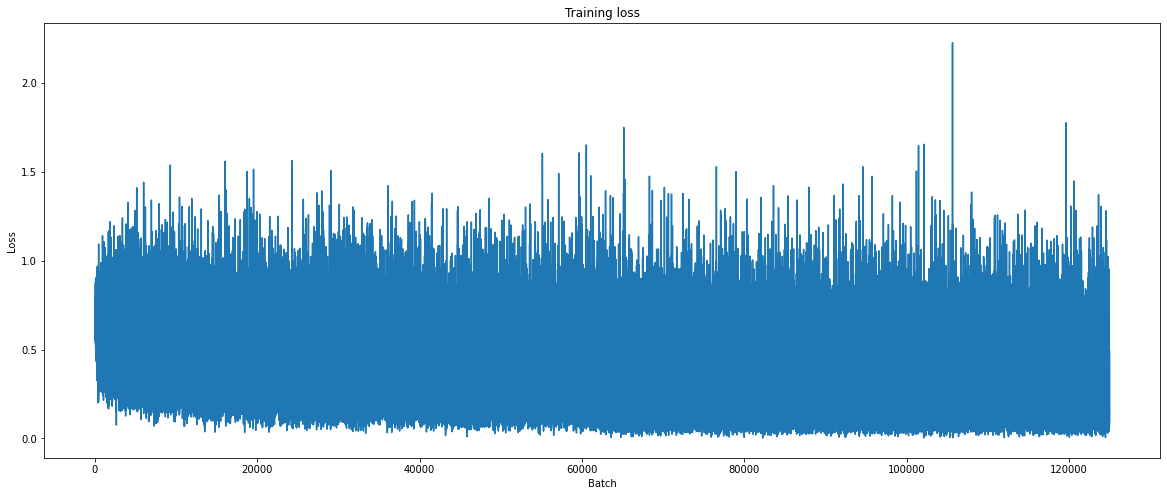

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

## Evaluation.

In [19]:
torch.cuda.empty_cache()
#model = torch.load("../models/BERT_model.pt")
model.eval()
preds = []

for i in range(int(len(test_inputs)/10)):
    batch = (test_inputs[i*10: (i+1)*10].to(device), test_masks[i*10: (i+1)*10].to(device))
    with torch.no_grad():
        logits = model(batch[0], token_type_ids=None, attention_mask = batch[1])[0]
    
    logits = logits.detach().cpu().numpy()
    preds.append(logits)
    if i%100 == 0:
        print("Processing: ", i*10/1000, "%")

Processing:  0.0 %
Processing:  1.0 %
Processing:  2.0 %
Processing:  3.0 %
Processing:  4.0 %
Processing:  5.0 %
Processing:  6.0 %
Processing:  7.0 %
Processing:  8.0 %
Processing:  9.0 %
Processing:  10.0 %
Processing:  11.0 %
Processing:  12.0 %
Processing:  13.0 %
Processing:  14.0 %
Processing:  15.0 %
Processing:  16.0 %
Processing:  17.0 %
Processing:  18.0 %
Processing:  19.0 %
Processing:  20.0 %
Processing:  21.0 %
Processing:  22.0 %
Processing:  23.0 %
Processing:  24.0 %
Processing:  25.0 %
Processing:  26.0 %
Processing:  27.0 %
Processing:  28.0 %
Processing:  29.0 %
Processing:  30.0 %
Processing:  31.0 %
Processing:  32.0 %
Processing:  33.0 %
Processing:  34.0 %
Processing:  35.0 %
Processing:  36.0 %
Processing:  37.0 %
Processing:  38.0 %
Processing:  39.0 %
Processing:  40.0 %
Processing:  41.0 %
Processing:  42.0 %
Processing:  43.0 %
Processing:  44.0 %
Processing:  45.0 %
Processing:  46.0 %
Processing:  47.0 %
Processing:  48.0 %
Processing:  49.0 %
Processing

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
predictions = []

print(len(test['label']))
for pred in preds:
    p = np.argmax(pred, axis = 1)
    for label in p:
        predictions.append(label)
print(len(predictions))
print(classification_report(np.asarray(test["label"][:len(predictions)]), predictions, digits = 4))
print("Accuracy: ", accuracy_score(np.asarray(test["label"][:len(predictions)]), predictions))


### Metrics of the two models:

Gpt-2:
    - Accuracy: 0.85237
    - Precision: 0.8549
    - Recall: 0.8524
    - F1-score: 0.8509

BERT:
    - Accuracy: 0.8437
    - Precision: 0.8443
    - Recall: 0.8437
    - F1-score: 0.8439 

If yopu want to save the fine-tuned model on bot detection task, you can do it with:

In [46]:
torch.save(model, "../models/GPT2_model.pt")